# Imports


In [255]:
import shap, matplotlib.pyplot as plt, numpy as np, pandas as pd, xgboost as xgb
from sklearn.compose      import ColumnTransformer
from sklearn.impute       import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection   import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing     import StandardScaler
from sklearn.pipeline          import make_pipeline, Pipeline
from sklearn.calibration       import CalibratedClassifierCV
from sklearn.metrics           import (precision_recall_curve, roc_curve, roc_auc_score,
                                       classification_report, confusion_matrix, f1_score)
from scipy.stats import randint, uniform
from xgboost import XGBClassifier

import seaborn as sns
from sklearn.metrics import (roc_curve, precision_recall_curve, 
                           roc_auc_score, average_precision_score,
                           confusion_matrix)
import shap


shap.initjs()
SEED = 42


In [256]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Define target and feature treatments
target = 'ptp3_yn'

feature_treatments = {
      'age': 'continuous',
      'race7': 'factor_nominal',
      'ethnic3': 'factor_nominal',
      'sex2': 'factor_nominal',
      'sig_other': 'factor_nominal',
      'tobacco': 'factor_nominal',
      'alcohol': 'factor_nominal',
      'drugs': 'factor_nominal',
      'MedianIncomeForZip': 'continuous',
      'PercentAboveHighSchoolEducationForZip': 'continuous',
      'PercentAboveBachelorsEducationForZip': 'continuous',
      'payertype': 'factor_nominal',
      'tbiS02': 'continuous',
      'tbiS06': 'continuous',
      'tbiS09': 'continuous',
      'ptp1_yn': 'factor_nominal',
      'ptp2_yn': 'factor_nominal',
      'ptp0_yn': 'factor_nominal',
      'ed_yn': 'factor_nominal',
      'icu': 'factor_nominal',
      'delirium': 'factor_nominal',
      'agitated': 'factor_nominal',
      'lethargic': 'factor_nominal',
      'comatose': 'factor_nominal',
      'disoriented': 'factor_nominal',
      'gcs_min': 'continuous',
      'gcs_max': 'continuous',
      'adl_min': 'continuous',
      'adl_max': 'continuous',
      'mobility_min': 'continuous',
      'mobility_max': 'continuous',
      'los_total': 'continuous',
      'dc_setting': 'factor_nominal',
      'prehosp': 'factor_nominal',
      'posthosp': 'factor_nominal',
}

dtype_mapping = {
    'continuous': 'float64',  # Use float64 for continuous data
    'factor_nominal': 'category' # Use category for nominal factors
}
dtype_dict = {col: dtype_mapping[treatment] for col, treatment in feature_treatments.items()}
dtype_dict['subj_id'] = 'object'
dtype_dict['ptp3_yn'] = 'int64'
dtype_dict['died'] = 'int64'


nominal_cols = [col for col, treatment in feature_treatments.items() if treatment == 'factor_nominal']
continuous_cols = [col for col, treatment in feature_treatments.items() if treatment == 'continuous']

path = r'/Users/mattstoebe/ClonedRepos/CSU_MAS_/Capstone/tbistaa556_training.csv'


df = pd.read_csv(path, dtype=dtype_dict, na_values=[' '])
features = [col for col in df.columns if col not in ['ptp3_yn', 'died', 'subj_id']]

# print(features)
# print(df.info())

X = df[features]
y = df[target]

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.40, stratify=y, random_state=SEED)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=SEED)

print(f"Train: {len(X_train)}  |  Val: {len(X_val)}  |  Test: {len(X_test)}")

Train: 5426  |  Val: 1809  |  Test: 1809


# Model Setup and Training

## Model Pipeline

In [257]:

scale_pos = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Scale pos weight: {scale_pos}")

Scale pos weight: 3.1706379707916987


In [258]:
preprocess = ColumnTransformer([
    ('num', 'passthrough', continuous_cols),                 # leave NaNs for XGB
    ('cat', Pipeline([
        ('imp', SimpleImputer(strategy='constant', fill_value='__NA__')),
        ('ohe', OneHotEncoder(handle_unknown='ignore'))
    ]), nominal_cols)
])

xgb_classifier = XGBClassifier(
    objective='binary:logistic',
    eval_metric='aucpr',
    tree_method='hist',
    random_state=SEED,
    n_jobs=-1
)

pipe = Pipeline([
    ('prep', preprocess),
    ('xgb',  xgb_classifier)
])

In [259]:
cat_features = []
for col in nominal_cols:
    unique_vals = X[col].unique()
    cat_features.extend([f"{col}_{val}" for val in unique_vals])

# Create preprocessing with feature names
preprocess = ColumnTransformer([
    ('num', 'passthrough', continuous_cols),
    ('cat', Pipeline([
        ('imp', SimpleImputer(strategy='constant', fill_value='__NA__')),
        ('ohe', OneHotEncoder(handle_unknown='ignore'))
    ]), nominal_cols)
], verbose_feature_names_out=True)

xgb_classifier = XGBClassifier(
    objective='binary:logistic',
    eval_metric='aucpr',
    tree_method='hist',
    random_state=SEED,
    n_jobs=-1
)

pipe = Pipeline([
    ('prep', preprocess),
    ('xgb',  xgb_classifier)
])

# Verify feature names
feature_names = (continuous_cols + cat_features)

print("Feature names after preprocessing:")
print(feature_names)

Feature names after preprocessing:
['age', 'MedianIncomeForZip', 'PercentAboveHighSchoolEducationForZip', 'PercentAboveBachelorsEducationForZip', 'tbiS02', 'tbiS06', 'tbiS09', 'gcs_min', 'gcs_max', 'adl_min', 'adl_max', 'mobility_min', 'mobility_max', 'los_total', 'race7_0', 'race7_5', 'race7_6', 'race7_nan', 'race7_3', 'race7_1', 'race7_4', 'race7_2', 'ethnic3_1', 'ethnic3_2', 'ethnic3_0', 'sex2_2', 'sex2_1', 'sex2_0', 'sig_other_0', 'sig_other_1', 'sig_other_2', 'tobacco_0', 'tobacco_2', 'tobacco_1', 'alcohol_0', 'alcohol_2', 'alcohol_1', 'drugs_0', 'drugs_2', 'drugs_1', 'payertype_3', 'payertype_5', 'payertype_2', 'payertype_4', 'payertype_1', 'ptp1_yn_2', 'ptp1_yn_1', 'ptp2_yn_1', 'ptp2_yn_2', 'ptp0_yn_1', 'ptp0_yn_2', 'ed_yn_0', 'ed_yn_1', 'ed_yn_2', 'icu_1', 'icu_2', 'delirium_0', 'delirium_2', 'delirium_1', 'agitated_2', 'agitated_1', 'agitated_0', 'lethargic_1', 'lethargic_2', 'lethargic_0', 'comatose_1', 'comatose_2', 'comatose_0', 'disoriented_0', 'disoriented_1', 'disoriente

In [260]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['age', 'MedianIncomeForZip',
                                                   'PercentAboveHighSchoolEducationForZip',
                                                   'PercentAboveBachelorsEducationForZip',
                                                   'tbiS02', 'tbiS06', 'tbiS09',
                                                   'gcs_min', 'gcs_max',
                                                   'adl_min', 'adl_max',
                                                   'mobility_min',
                                                   'mobility_max',
                                                   'los_total']),
                                                 ('cat',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(fill_value=...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=-1,
                               num_parallel_tree=None, ...))])

## Evaluate Untuned Model

In [261]:
y_val_pred = pipe.predict(X_val)
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1375
           1       0.73      0.67      0.70       434

    accuracy                           0.86      1809
   macro avg       0.81      0.80      0.80      1809
weighted avg       0.86      0.86      0.86      1809



## Model Tuning

In [262]:
param_dist = {
    'xgb__max_depth': randint(3, 7),        # Reduced range
    'xgb__learning_rate': uniform(0.01, 0.2),
    'xgb__n_estimators': randint(100, 500), # Reduced range
    
    'xgb__min_child_weight': randint(1, 6)  # Reduced range
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

search = RandomizedSearchCV(
    pipe,
    param_distributions=param_dist,
    n_iter=20,
    scoring='average_precision',
    cv=cv,
    random_state=SEED,
    n_jobs=-1,
    verbose=1
)

In [263]:
reTune = True
if reTune:
    search.fit(X_train, y_train)
    best_params = search.best_params_
else: 
    best_params = {
        'xgb__learning_rate': np.float64(0.0849080237694725),
        'xgb__max_depth': 3,
        'xgb__min_child_weight': 3,
        'xgb__n_estimators': 171
    }

print(f"Best params: {best_params}")
best_params = {k.replace('xgb__', ''): v for k, v in search.best_params_.items()}


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params: {'xgb__learning_rate': np.float64(0.0849080237694725), 'xgb__max_depth': 3, 'xgb__min_child_weight': 3, 'xgb__n_estimators': 171}


## Evaluate Tuned Model

In [264]:
pipe.named_steps['xgb'].set_params(**best_params)
pipe.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['age', 'MedianIncomeForZip',
                                                   'PercentAboveHighSchoolEducationForZip',
                                                   'PercentAboveBachelorsEducationForZip',
                                                   'tbiS02', 'tbiS06', 'tbiS09',
                                                   'gcs_min', 'gcs_max',
                                                   'adl_min', 'adl_max',
                                                   'mobility_min',
                                                   'mobility_max',
                                                   'los_total']),
                                                 ('cat',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(fill_value=...
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=np.float64(0.0849080237694725),
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None, min_child_weight=3,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=171, n_jobs=-1,
                               num_parallel_tree=None, ...))])

In [265]:
y_val_pred = pipe.predict(X_val)
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.90      0.95      0.93      1375
           1       0.80      0.68      0.74       434

    accuracy                           0.88      1809
   macro avg       0.85      0.81      0.83      1809
weighted avg       0.88      0.88      0.88      1809



# Select Thresholds

In [266]:
val_probs = pipe.predict_proba(X_val)[:, 1]

## Tau

Optimal threshold: 0.454

 VALIDATION Metrics with optimized threshold:
              precision    recall  f1-score   support

           0       0.91      0.94      0.93      1375
           1       0.79      0.71      0.75       434

    accuracy                           0.89      1809
   macro avg       0.85      0.83      0.84      1809
weighted avg       0.88      0.89      0.88      1809



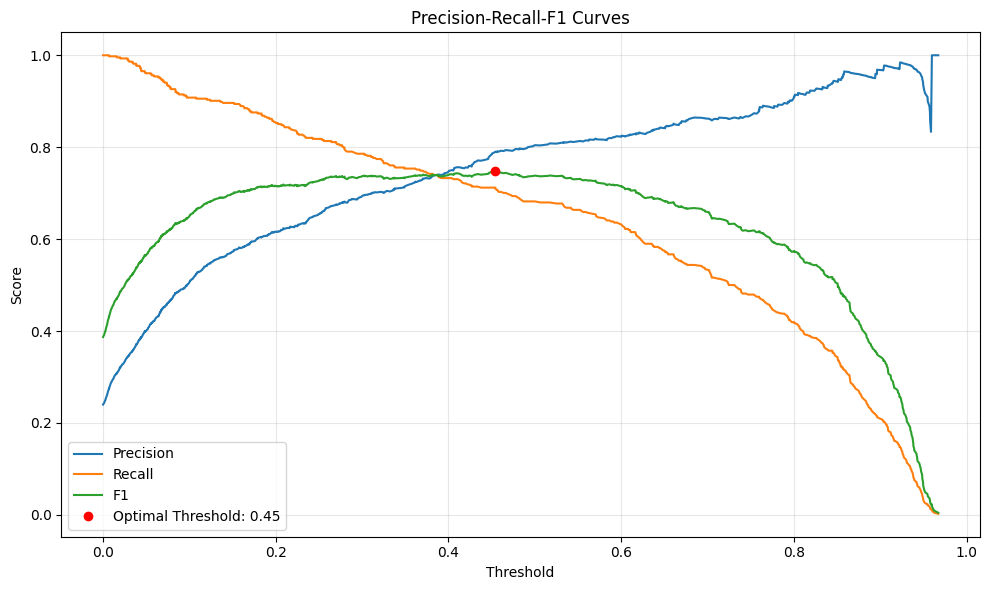

In [267]:

precisions, recalls, thresholds = precision_recall_curve(y_val, val_probs)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

# Create plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.plot(thresholds, f1_scores[:-1], label='F1')

plt.plot(optimal_threshold, f1_scores[optimal_idx], 'ro', 
         label=f'Optimal Threshold: {optimal_threshold:.2f}')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall-F1 Curves')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

final_preds = (val_probs >= optimal_threshold).astype(int)

print(f"Optimal threshold: {optimal_threshold:.3f}")
print("\n VALIDATION Metrics with optimized threshold:")
print(classification_report(y_val, final_preds))

## Risk Levels

In [268]:
print(y_val.size)

1809


τ_low: 0.066, τ_high: 0.492

Validation Risk Band Metrics:
           Size  Prevalence  Count
risk_band                         
Low         873    0.025200   22.0
Mid         567    0.204586  116.0
High        369    0.802168  296.0

Target Metrics:
High Risk Precision: 80.2% (target ≥80%)
Mid+High Recall:     94.9% (target ≥95%)


/var/folders/qn/ym1r3jwd09bd1qv7nhf7c9v40000gn/T/ipykernel_47193/4098392198.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  'Prevalence': val_results.groupby('risk_band')['true_label'].mean()


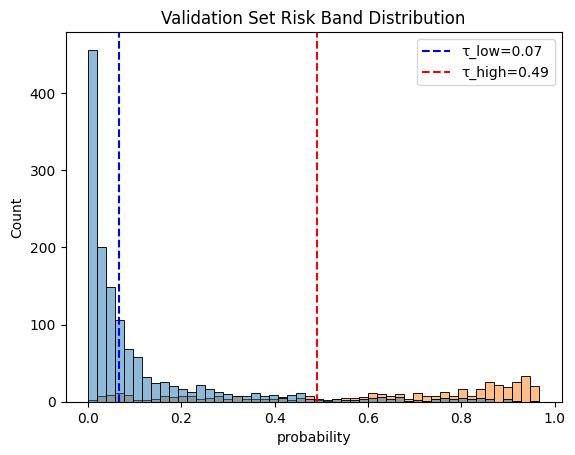

In [269]:
P_TARGET = 0.80
R_TARGET = 0.95

prec, rec, thr = precision_recall_curve(y_val, val_probs)
prec, rec, thr = prec[:-1], rec[:-1], thr

# Find tau_high
idx_hi = np.where(prec >= P_TARGET)[0]
tau_high = thr[idx_hi[0]] if len(idx_hi) > 0 else 1.0

# Find tau_low
mask = thr < tau_high
thr_sub, rec_sub = thr[mask], rec[mask]
idx_low = np.where(rec_sub >= R_TARGET)[0]
tau_low = thr_sub[idx_low[-1]] if len(idx_low) > 0 else 0.0

# Print thresholds
print(f"τ_low: {tau_low:.3f}, τ_high: {tau_high:.3f}")


# 3. Create validation results DataFrame
val_results = pd.DataFrame({
    'true_label': y_val,
    'probability': val_probs,
})

val_results["risk_band"] = pd.cut(
    val_results['probability'],
    bins=[-np.inf, tau_low, tau_high, np.inf],
    labels=['Low', 'Mid', 'High']
)

# Plot distribution and Cutoffs
sns.histplot(data=val_results, x='probability', hue='true_label', bins=50)
plt.axvline(tau_low, ls='--', c='blue', label=f'τ_low={tau_low:.2f}')
plt.axvline(tau_high, ls='--', c='red', label=f'τ_high={tau_high:.2f}')
plt.title('Validation Set Risk Band Distribution')
plt.legend()

# Get Size of each band and prevelance of PTP in each band.
val_metrics = pd.DataFrame({
    'Size': val_results['risk_band'].value_counts(),
    'Prevalence': val_results.groupby('risk_band')['true_label'].mean()
}).reindex(['Low', 'Mid', 'High'])
val_metrics['Count'] = (val_metrics['Size'] * val_metrics['Prevalence']).round(0)

print("\nValidation Risk Band Metrics:")
print(val_metrics)


# Calculate Target Performance to compare against targets
high_mask = val_results['risk_band'] == 'High'
mid_mask = val_results['risk_band'] == 'Mid'
high_precision = val_results[high_mask]['true_label'].mean()
mid_high_recall = (val_results[high_mask | mid_mask]['true_label'].sum() / 
                  val_results['true_label'].sum())

print(f"\nTarget Metrics:")
print(f"High Risk Precision: {high_precision:.1%} (target ≥{P_TARGET:.0%})")
print(f"Mid+High Recall:     {mid_high_recall:.1%} (target ≥{R_TARGET:.0%})")

# Train on Full Train set for final evaluation

In [270]:
X_full_train = pd.concat([X_train, X_val], axis=0)
y_full_train = pd.concat([y_train, y_val], axis=0)

best_params = {k.replace('xgb__', ''): v for k, v in search.best_params_.items()}
pipe.named_steps['xgb'].set_params(**best_params)
pipe.fit(X_full_train, y_full_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['age', 'MedianIncomeForZip',
                                                   'PercentAboveHighSchoolEducationForZip',
                                                   'PercentAboveBachelorsEducationForZip',
                                                   'tbiS02', 'tbiS06', 'tbiS09',
                                                   'gcs_min', 'gcs_max',
                                                   'adl_min', 'adl_max',
                                                   'mobility_min',
                                                   'mobility_max',
                                                   'los_total']),
                                                 ('cat',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(fill_value=...
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=np.float64(0.0849080237694725),
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None, min_child_weight=3,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=171, n_jobs=-1,
                               num_parallel_tree=None, ...))])

In [271]:
test_probs = pipe.predict_proba(X_test)[:, 1]
test_preds = (test_probs >= optimal_threshold).astype(int)

## Evaluate on Test Data

In [272]:
print("\nFinal Test Set Performance:")
print(classification_report(y_test, test_preds))


Final Test Set Performance:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1375
           1       0.76      0.71      0.74       434

    accuracy                           0.88      1809
   macro avg       0.84      0.82      0.83      1809
weighted avg       0.88      0.88      0.88      1809



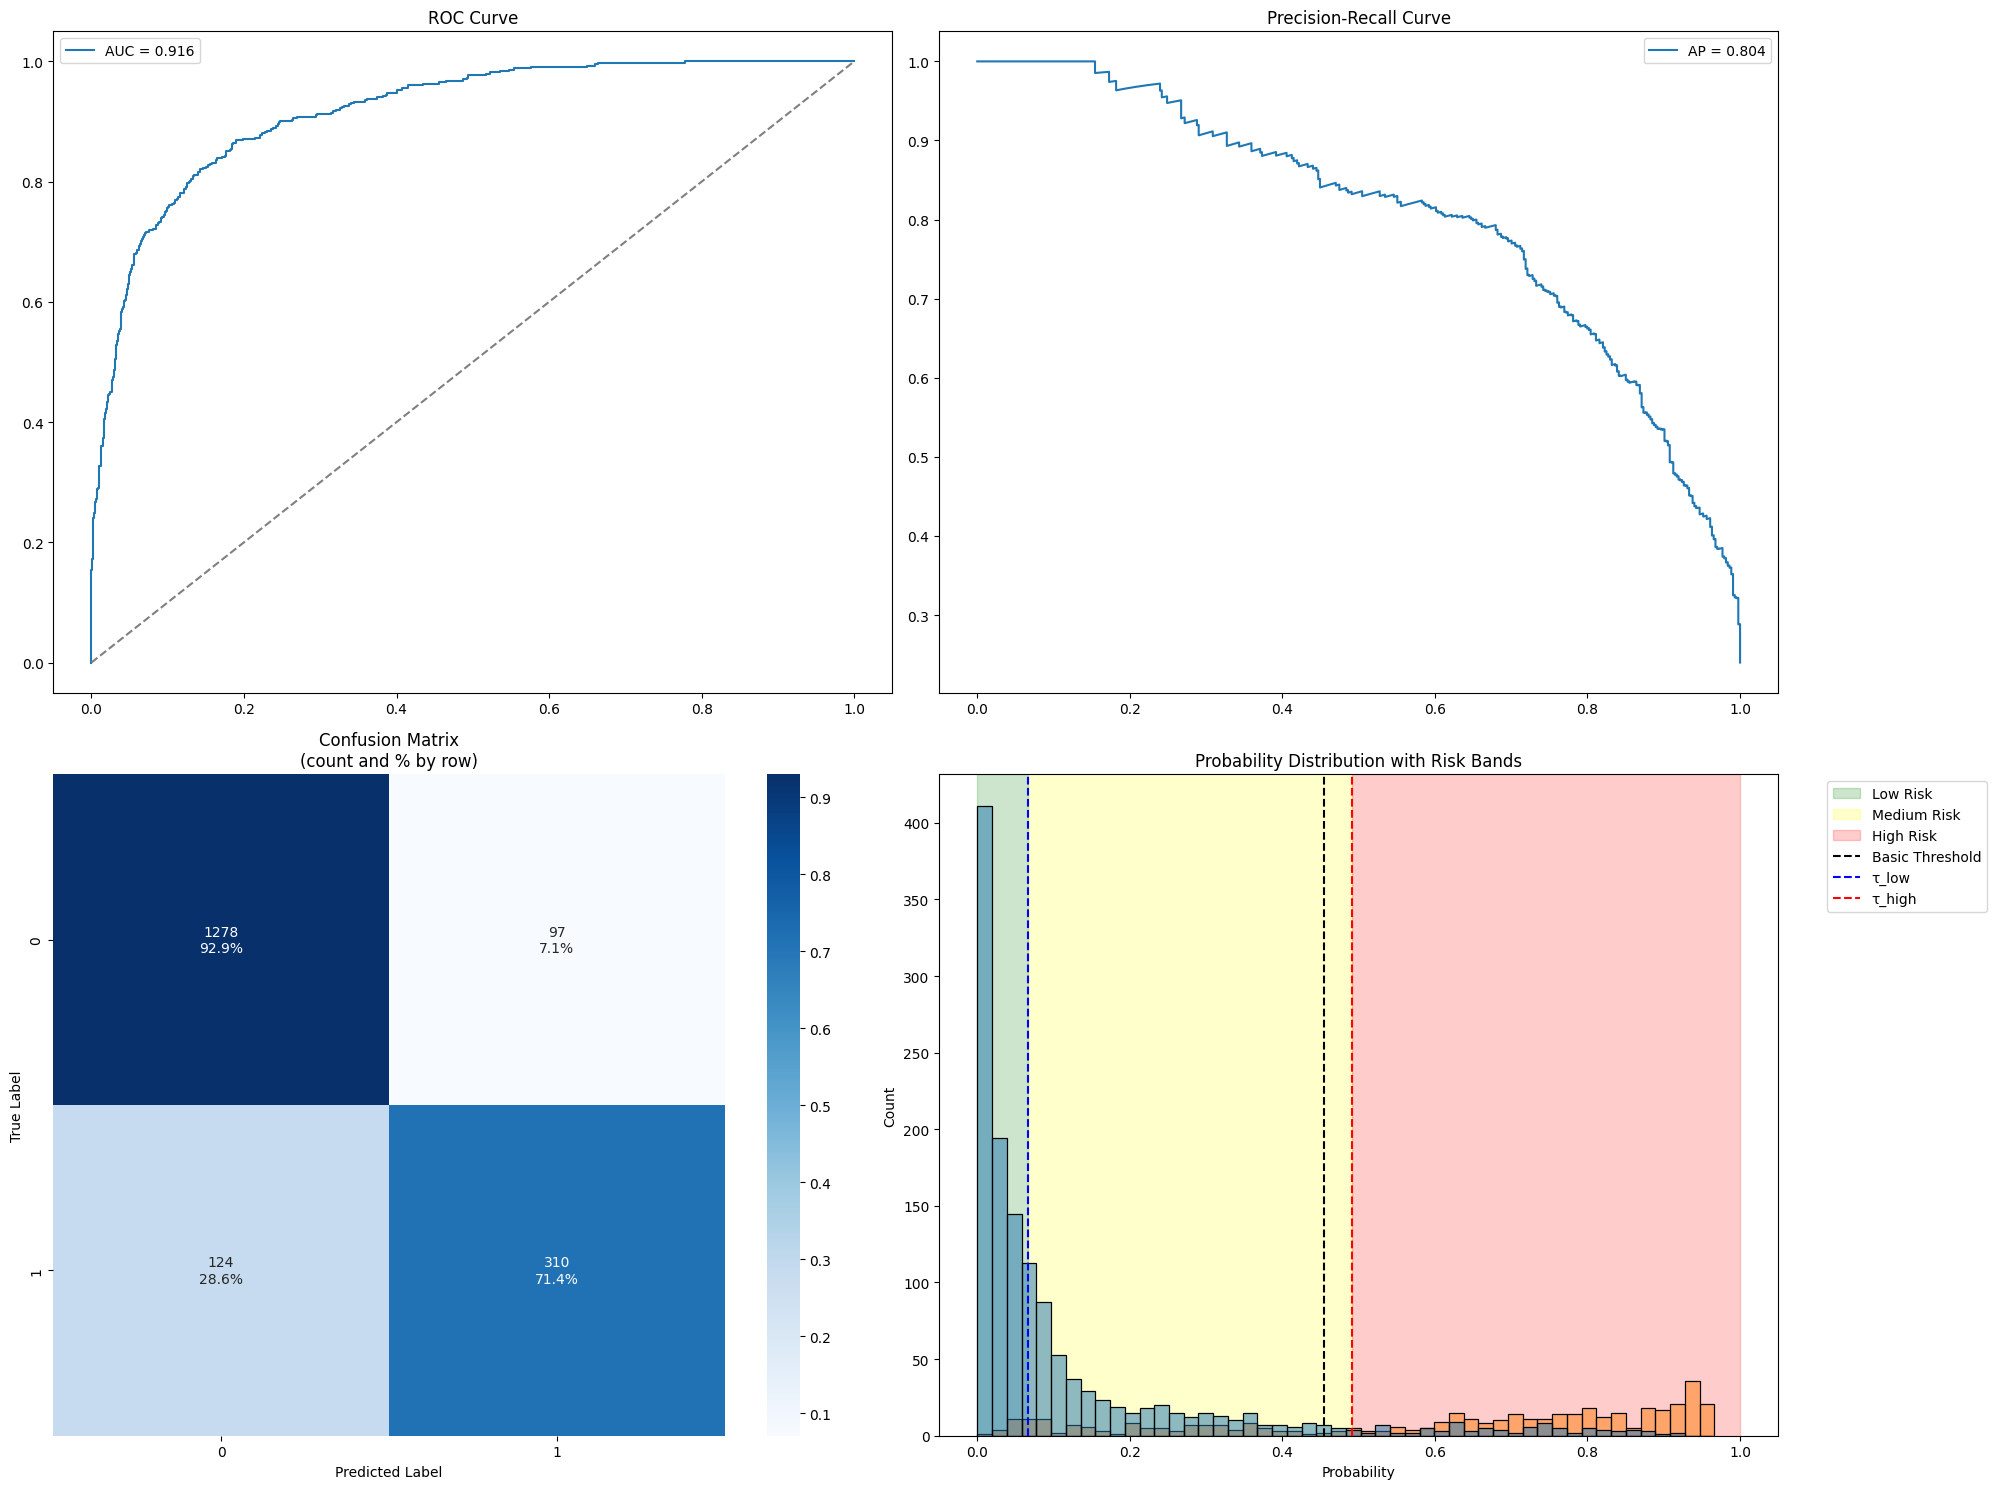

In [273]:
fig, axs = plt.subplots(2, 2, figsize=(20, 15))

# ROC and PR Curves (Row 1)
fpr, tpr, _ = roc_curve(y_test, test_probs)
auc_score = roc_auc_score(y_test, test_probs)
axs[0,0].plot(fpr, tpr, label=f'AUC = {auc_score:.3f}')
axs[0,0].plot([0,1], [0,1], '--', color='gray')
axs[0,0].set_title('ROC Curve')
axs[0,0].legend()

precision, recall, _ = precision_recall_curve(y_test, test_probs)
ap_score = average_precision_score(y_test, test_probs)
axs[0,1].plot(recall, precision, label=f'AP = {ap_score:.3f}')
axs[0,1].set_title('Precision-Recall Curve')
axs[0,1].legend()

# Confusion Matrix and Basic Prob Dist (Row 2)
cm = confusion_matrix(y_test, test_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, 
            annot=np.array([[f'{val}\n{ratio:.1%}' 
                            for val, ratio in zip(row_raw, row_norm)]
                            for row_raw, row_norm in zip(cm, cm_normalized)]),
            fmt='',
            cmap='Blues',
            ax=axs[1,0])
axs[1,0].set(xlabel='Predicted Label', 
             ylabel='True Label',
             title='Confusion Matrix\n(count and % by row)')


plt.sca(axs[1,1])
# Add background shading for risk bands
plt.axvspan(0, tau_low, alpha=0.2, color='green', label='Low Risk')
plt.axvspan(tau_low, tau_high, alpha=0.2, color='yellow', label='Medium Risk')
plt.axvspan(tau_high, 1, alpha=0.2, color='red', label='High Risk')

# Plot distribution
sns.histplot(data=pd.DataFrame({
    'Probability': test_probs,
    'True Label': y_test
}), x='Probability', hue='True Label', bins=50)

# Add threshold lines
plt.axvline(optimal_threshold, color='black', linestyle='--', label='Basic Threshold')
plt.axvline(tau_low, color='blue', linestyle='--', label='τ_low')
plt.axvline(tau_high, color='red', linestyle='--', label='τ_high')

plt.title('Probability Distribution with Risk Bands')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

## Risk Band Target Accuracy

In [274]:

test_results = pd.DataFrame({
    'true_label': y_test,
    'probability': test_probs,
    'risk_band': pd.cut(test_probs, 
                       bins=[-np.inf, tau_low, tau_high, np.inf],
                       labels=['Low', 'Mid', 'High'])
})


test_metrics = pd.DataFrame({
    'Size': test_results['risk_band'].value_counts(),
    'Proportion': test_results['risk_band'].value_counts() / len(test_results),
    'Prevalence': test_results.groupby('risk_band')['true_label'].mean()
}).reindex(['Low', 'Mid', 'High'])

# Add counts
test_metrics['True_Cases'] = (test_metrics['Size'] * test_metrics['Prevalence']).round(0)

# Calculate target metrics
high_mask = test_results['risk_band'] == 'High'
mid_mask = test_results['risk_band'] == 'Mid'
high_precision = test_results[high_mask]['true_label'].mean()
mid_high_recall = (test_results[high_mask | mid_mask]['true_label'].sum() / 
                  test_results['true_label'].sum())

# Print comprehensive metrics
print("\nRisk Band Performance (Test Set):")
print(test_metrics)
print(f"\nTarget Metrics:")
print(f"High Risk Precision: {high_precision:.1%} (target ≥{P_TARGET:.0%})")
print(f"Mid+High Recall:     {mid_high_recall:.1%} (target ≥{R_TARGET:.0%})")


Risk Band Performance (Test Set):
           Size  Proportion  Prevalence  True_Cases
risk_band                                          
Low         826    0.456606    0.023002        19.0
Mid         591    0.326700    0.189509       112.0
High        392    0.216694    0.772959       303.0

Target Metrics:
High Risk Precision: 77.3% (target ≥80%)
Mid+High Recall:     95.6% (target ≥95%)


/var/folders/qn/ym1r3jwd09bd1qv7nhf7c9v40000gn/T/ipykernel_47193/797267770.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  'Prevalence': test_results.groupby('risk_band')['true_label'].mean()


## Feature Importance

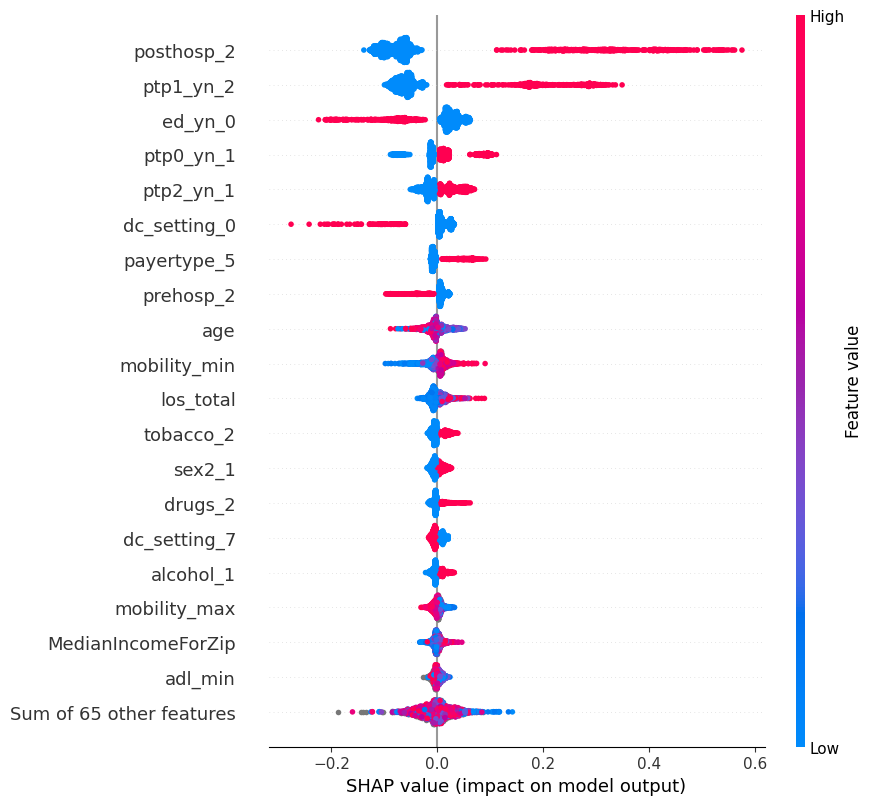

In [275]:
X_proc = pipe[:-1].transform(X_test)
if hasattr(X_proc, "toarray"):
    X_proc = X_proc.toarray()

explainer = shap.TreeExplainer(
    pipe['xgb'],
    X_proc,                       # background (can subsample for speed)
    model_output='probability',   # <<< everything now 0-1
    feature_names=feature_names
)

shap_values_prob = explainer(X_proc)

plt.figure(figsize=(12, 8))
shap.plots.beeswarm(shap_values_prob, max_display=20)
plt.show()


In [276]:
def analyze_top_predictors(idx=None, random_seed=None, figsize=(10,12)):
    if idx is None:
        if random_seed is not None:          # reproducible run
            np.random.seed(random_seed)
        idx = np.random.randint(len(X_test)) # different every call if seed is None

    single_record   = X_test.iloc[[idx]]
    X_proc_single   = pipe[:-1].transform(single_record)
    if hasattr(X_proc_single, "toarray"):
        X_proc_single = X_proc_single.toarray()

    feature_names = pipe[:-1].get_feature_names_out()

    explainer     = shap.TreeExplainer(pipe['xgb'],
                                       pipe[:-1].transform(X_train),
                                       model_output='probability',
                                       feature_names=feature_names
                                       )
    sv_prob       = explainer(X_proc_single)

    # top-5 features
    abs_vals      = np.abs(sv_prob.values[0])
    top_idx       = np.argsort(abs_vals)[-5:][::-1]

    results = pd.DataFrame({
        "Feature"   : feature_names[top_idx],
        "Impact"    : sv_prob.values[0, top_idx],
        "Value"     : X_proc_single[0, top_idx],
        "Direction" : ["Increases" if v > 0 else "Decreases"
                       for v in sv_prob.values[0, top_idx]]
    })

    fig = plt.figure(figsize=figsize)
    plt.title(f"Predicted P = {sv_prob.base_values[0] + sv_prob.values[0].sum():.3f}")
    plt.xlim(0, 1)          # ← keep the probability scale fixed
    shap.plots.waterfall(sv_prob[0], max_display=7)
    plt.tight_layout()
    return results, fig

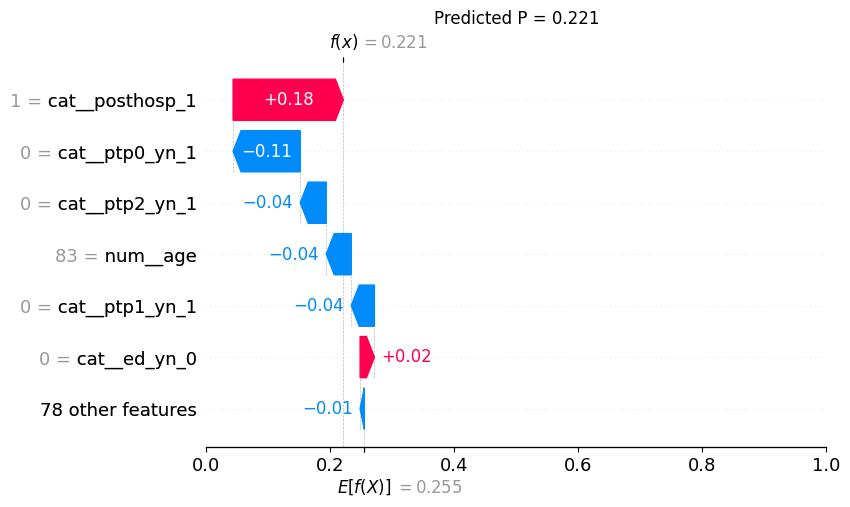

<Figure size 640x480 with 0 Axes>

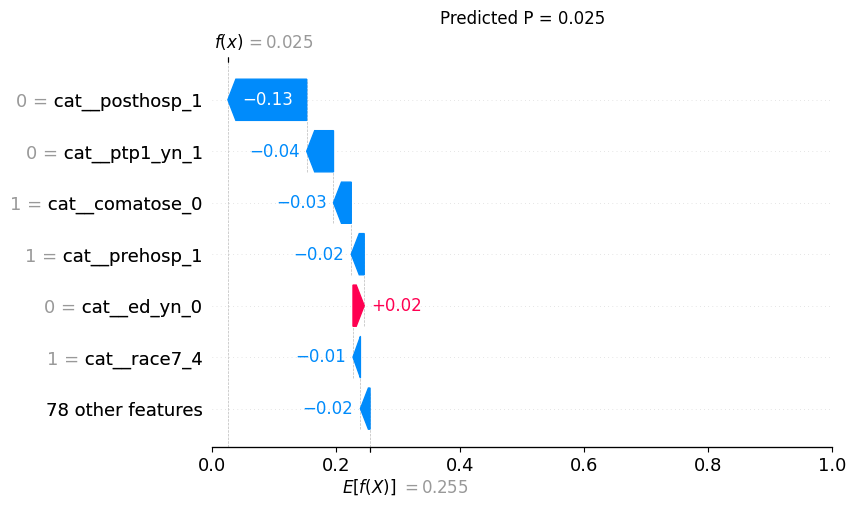

<Figure size 640x480 with 0 Axes>

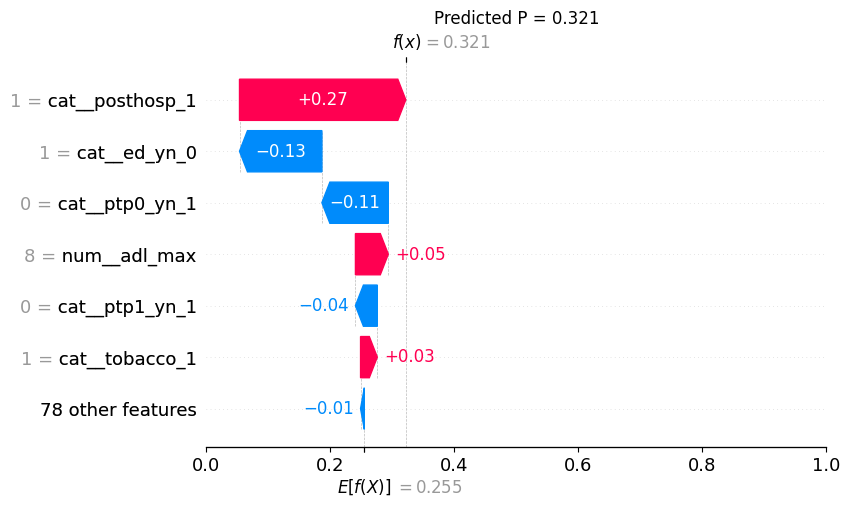

(           Feature    Impact  Value  Direction
 0  cat__posthosp_1  0.268221    1.0  Increases
 1     cat__ed_yn_0 -0.132897    1.0  Decreases
 2   cat__ptp0_yn_1 -0.107108    0.0  Decreases
 3     num__adl_max  0.053026    8.0  Increases
 4   cat__ptp1_yn_1 -0.035284    0.0  Decreases,
 <Figure size 800x500 with 3 Axes>)

<Figure size 640x480 with 0 Axes>

In [277]:
analyze_top_predictors()
analyze_top_predictors()
analyze_top_predictors()

# Save Model

In [278]:
import joblib
from datetime import datetime

# Fit final model and save package
pipe.fit(X,y)


model_package = {
    'pipeline': pipe,
    'thresholds': {
        'optimal_threshold': optimal_threshold,
        'tau_low': tau_low,
        'tau_high': tau_high
    },
    'targets': {
        'P_TARGET': P_TARGET,
        'R_TARGET': R_TARGET
    },
    'metadata': {
        'train_date': datetime.now().strftime("%Y-%m-%d"),
        'n_features': X_full_train.shape[1],
        'n_samples': X_full_train.shape[0]
    }
}


timestamp = datetime.now().strftime("%Y%m%d_%H%M")
joblib.dump(model_package, f'models/xgb_model.pkl')

['models/xgb_model.pkl']